In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.linalg import svd

import torch
import torch.nn.functional as F
from collections import defaultdict

In [3]:
ALPHA = 0.5
coefs_LASSO = pd.read_csv(f'LASSO_coef_alpha_{ALPHA}_NO_PV.csv', header=0, index_col=0)
coefs_LASSO

,Coefficients importance
CNTRYID,1.570051
CNTSCHID,0.000000
CNTSTUID,0.000000
OECD,-3.191918
ADMINMODE,-1.236478
...,...
CREATACT,0.000000
CREATOPN,-1.335293
CREATOR,-0.000000
UNIT,-0.000000


In [4]:
def get_dataset(mode='train'):
    X = pd.read_csv(f'../cleaned_data/X_{mode}.csv', header=0, index_col=0)
    y = pd.read_csv(f'../cleaned_data/y_{mode}.csv', header=None, index_col=None).values.ravel()

    X = X.set_index(["CNTSTUID"])
    X = X.filter(items=coefs_LASSO[coefs_LASSO["Coefficients importance"] != 0].index)
    X = X.drop(columns=X.filter(regex="PV.*").columns)

    df = pd.DataFrame({
        "y": y,
        "CNTSTUID": X.index
    }).set_index("CNTSTUID")

    df = df.merge(X, left_index=True, right_index=True)

    df_drop = (df[df["CNTRYID"].isin([2, 5, 76, 36, 57])].set_index("CNTRYID", append=True).notna().reset_index(level=1).groupby("CNTRYID").sum() == 0).sum(axis=0) > 0
    df_drop = df_drop[df_drop]
    df = df.drop(columns=df_drop.index)
    df = df[df['CNTRYID'].isin({2, 5, 36, 57, 76})]

    encoded_df = pd.get_dummies(df, columns=['CNTRYID'], prefix='CNTRYID', dtype=int)
    A = encoded_df.filter(like='CNTRYID')

    # drop components of A from data
    encoded_df = encoded_df.drop(columns=encoded_df.filter(like='CNTRYID').columns)
    
    X = encoded_df.drop(columns=['y'])
    y = encoded_df['y']

    return X, y, A

def plot_question_hist(X, A):
    fig, ax = plt.subplots(3, sharex=True)
    question = "ST253Q01JA"
    fig.suptitle("How many [digital devices] with screens are there in your [home]?")
    fig.tight_layout()

    X[A["CNTRYID_5"] == 1][question].hist(alpha=0.5, color="green", ax=ax[0])
    X[A["CNTRYID_2"] == 1][question].hist(alpha=0.5, color="blue", ax=ax[0])
    ax[0].set_title('Australia (green), Belgium (blue)')
    X[A["CNTRYID_76"] == 1][question].hist(alpha=0.5, color="black", ax=ax[1])
    ax[1].set_title('United States')
    X[A["CNTRYID_57"] == 1][question].hist(alpha=0.5, color="red", ax=ax[2])
    X[A["CNTRYID_36"] == 1][question].hist(alpha=0.5, color="yellow", ax=ax[2])
    ax[2].set_title('Philippines (red), Jordan (yellow)')

In [5]:
X_train, y_train, A_train = get_dataset(mode='train')
X_train.shape, y_train.shape, A_train.shape

((20563, 348), (20563,), (20563, 5))

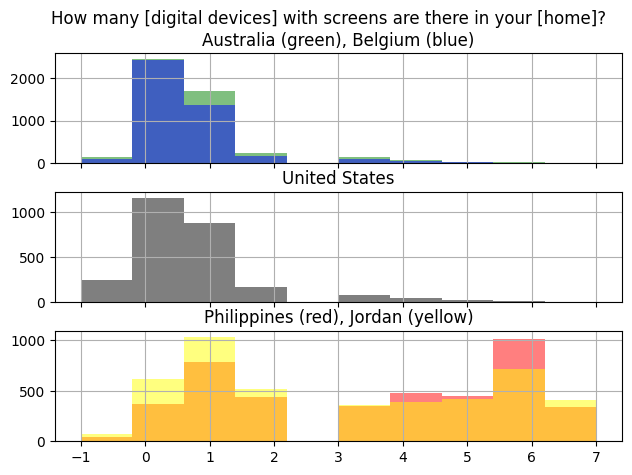

In [6]:
plot_question_hist(X_train, A_train)

In [7]:
question = "ST253Q01JA"
mask_mode1 = ((A_train["CNTRYID_57"] == 1) | (A_train["CNTRYID_36"] == 1)) & (X_train[question] < 3)
mask_mode2 = ((A_train["CNTRYID_57"] == 1) | (A_train["CNTRYID_36"] == 1)) & (X_train[question] >= 3)
mask_tail1 = ((A_train["CNTRYID_57"] == 1) | (A_train["CNTRYID_36"] == 1)) & (X_train[question] < 6)
mask_tail2 = ((A_train["CNTRYID_57"] == 1) | (A_train["CNTRYID_36"] == 1)) & (X_train[question] > 0)
mask_usausbel = ((A_train["CNTRYID_57"] == 1) | (A_train["CNTRYID_36"] == 1))

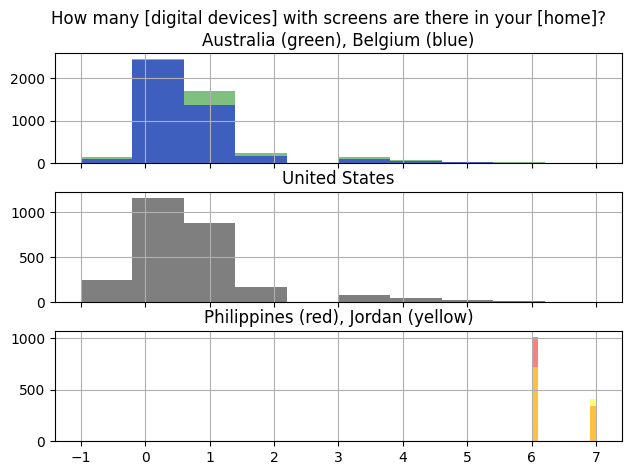

In [8]:
mask = mask_tail1
plot_question_hist(X_train[~mask], A_train[~mask])

In [9]:
X_test, y_test, A_test = get_dataset(mode='val')
X_test.shape, y_test.shape, A_test.shape

((13539, 348), (13539,), (13539, 5))

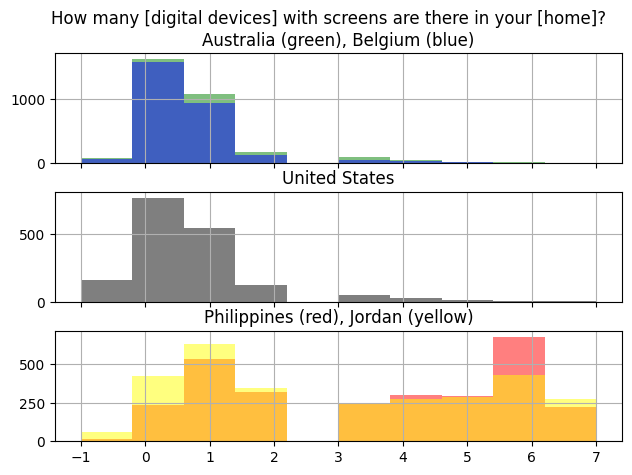

In [10]:
plot_question_hist(X_test, A_test)

In [11]:
def unnormalize(x, mean, std):
    return (x*std) + mean

In [12]:
def anchor_reg(X_tr, y_tr, proj_A, X_test, y_test, gammas):
    mses = {
        'United States': [],
        'Australia': [],
        'Belgium': [],
        'Philippines': [],
        'Jordan': []
    }
    maes = {
        'United States': [],
        'Australia': [],
        'Belgium': [],
        'Philippines': [],
        'Jordan': []
    }
    Id = np.eye(proj_A.shape[0])
    for gamma in tqdm(gammas):

        y_train_tilde = (Id + (np.sqrt(gamma) - 1)*proj_A) @ y_tr
        X_train_tilde = (Id + (np.sqrt(gamma) - 1)*proj_A) @ X_tr
        
        model = LinearRegression()
        model.fit(X_train_tilde, y_train_tilde)

        y_test_pred = model.predict(X_test)

        # Get errors for US
        mask = A_test['CNTRYID_76'] == 1
        mses['United States'].append(mean_squared_error(y_test[mask], y_test_pred[mask]))
        maes['United States'].append(mean_absolute_error(y_test[mask], y_test_pred[mask]))

        # Get errors for Australia
        mask = A_test['CNTRYID_5'] == 1
        mses['Australia'].append(mean_squared_error(y_test[mask], y_test_pred[mask]))
        maes['Australia'].append(mean_absolute_error(y_test[mask], y_test_pred[mask]))

        # Get errors for Belgium
        mask = A_test['CNTRYID_2'] == 1
        mses['Belgium'].append(mean_squared_error(y_test[mask], y_test_pred[mask]))
        maes['Belgium'].append(mean_absolute_error(y_test[mask], y_test_pred[mask]))

        # Get errors for Philippines
        mask = A_test['CNTRYID_57'] == 1
        mses['Philippines'].append(mean_squared_error(y_test[mask], y_test_pred[mask]))
        maes['Philippines'].append(mean_absolute_error(y_test[mask], y_test_pred[mask]))

        # Get errors for Jordan
        mask = A_test['CNTRYID_36'] == 1
        mses['Jordan'].append(mean_squared_error(y_test[mask], y_test_pred[mask]))
        maes['Jordan'].append(mean_absolute_error(y_test[mask], y_test_pred[mask]))
    
    return mses, maes

In [13]:
all_mses = {}
all_maes = {}

masks = [mask_mode1, mask_mode2, mask_tail1, mask_tail2, mask_usausbel]
gammas = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 100, 1000, 10000]
for mid, mask in enumerate(masks):
    print(f'Mask {mid+1}/{len(masks)}:')
    X_tr = X_train[~mask]
    A_tr = A_train[~mask]
    y_tr = y_train[~mask]

    A = A_tr.to_numpy()
    U, s, _ = svd(A)
    rank = np.sum(s > 1e-10)
    U_r = U[:, :rank]

    print(f'A.shape: {A.shape}, U_r.shape: {U_r.shape}')

    # get the projection matrix onto the column-space of A
    proj_A = U_r @ U_r.T    

    # Pre-process data
    data_processor = Pipeline([
            ('imputer', SimpleImputer(add_indicator=True)), 
            ('scaler', StandardScaler())
        ])
    data_processor.fit(X_tr)

    X_train_processed = data_processor.transform(X_tr)
    X_test_processed = data_processor.transform(X_test)

    # Normalize labels
    label_mean = y_tr.mean()
    label_std = y_tr.std()

    y_train_normalized = (y_tr - label_mean ) / label_std
    y_test_normalized = (y_test - label_mean ) / label_std

    mses, maes = anchor_reg(X_train_processed, y_train_normalized, proj_A, X_test_processed, y_test_normalized, gammas)
    all_mses[mid] = mses
    all_maes[mid] = maes
    

Mask 1/5:
A.shape: (16686, 5), U_r.shape: (16686, 5)


100%|██████████| 10/10 [01:41<00:00, 10.18s/it]


Mask 2/5:
A.shape: (15627, 5), U_r.shape: (15627, 5)


100%|██████████| 10/10 [01:29<00:00,  8.95s/it]


Mask 3/5:
A.shape: (14228, 5), U_r.shape: (14228, 5)


100%|██████████| 10/10 [01:14<00:00,  7.47s/it]


Mask 4/5:
A.shape: (12844, 5), U_r.shape: (12844, 5)


100%|██████████| 10/10 [01:01<00:00,  6.12s/it]


Mask 5/5:
A.shape: (11750, 5), U_r.shape: (11750, 3)


100%|██████████| 10/10 [00:51<00:00,  5.15s/it]


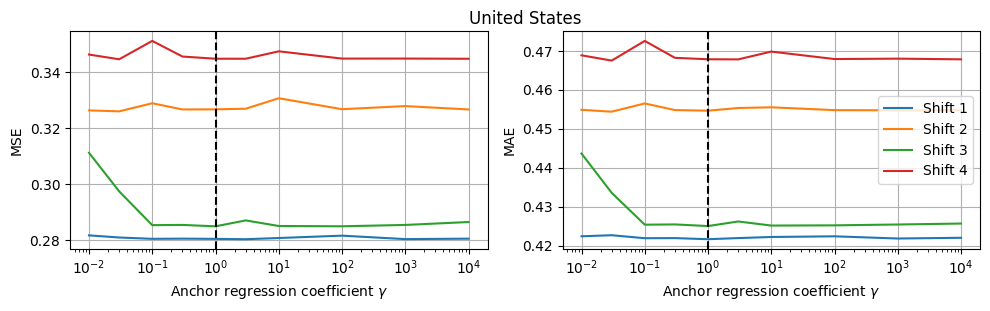

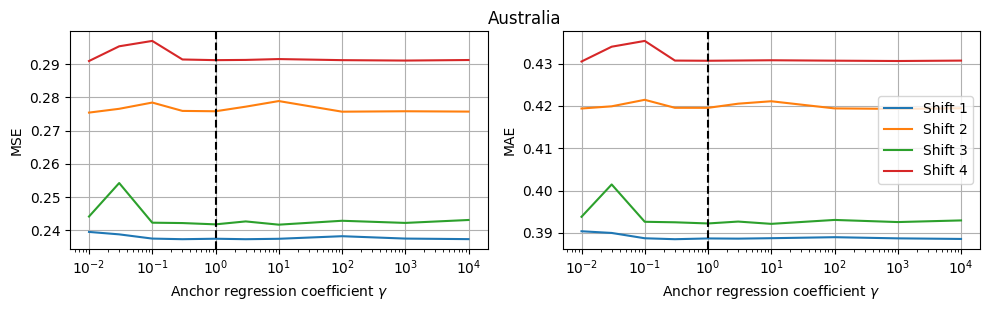

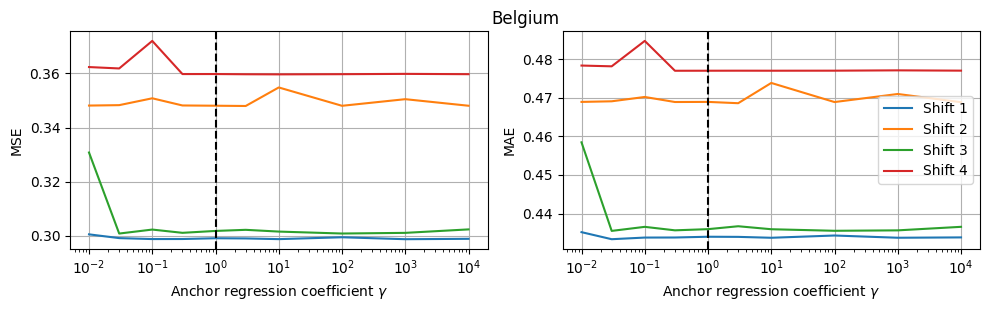

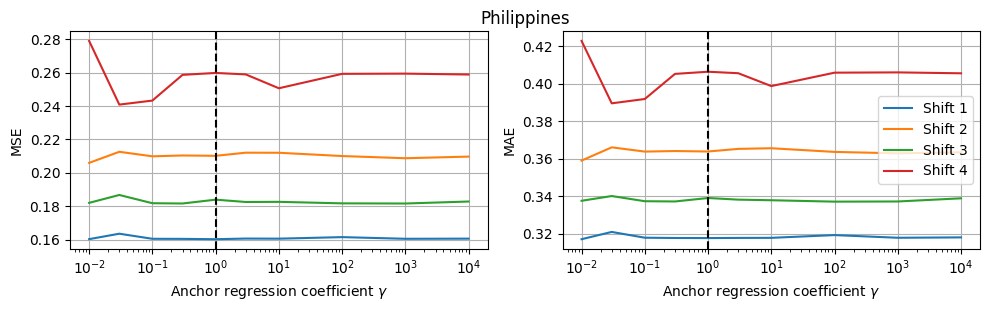

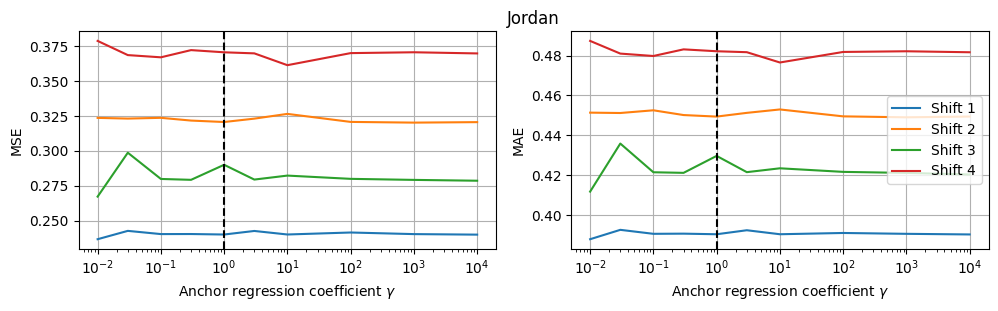

In [14]:
countries = [*all_mses[0].keys()]
for country in countries:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    for mid in all_mses:
        if mid <4:
            axes[0].plot(gammas, all_mses[mid][country], label=f'Shift {mid+1}')
    axes[0].axvline(x=1.0, c='k', linestyle='--')
    axes[0].set_xscale('log')
    axes[0].grid()
    axes[0].set_xlabel(r'Anchor regression coefficient $\gamma$')
    axes[0].set_ylabel('MSE')

    for mid in all_maes:
        if mid <4:
            axes[1].plot(gammas, all_maes[mid][country], label=f'Shift {mid+1}')
    axes[1].axvline(x=1.0, c='k', linestyle='--')
    axes[1].set_xscale('log')
    axes[1].grid()
    axes[1].set_xlabel(r'Anchor regression coefficient $\gamma$')
    axes[1].set_ylabel('MAE')

    axes[1].legend(loc='right', bbox_to_anchor=(1.0, 0.5), ncol=1)

    plt.tight_layout()
    fig.suptitle(country, x=0.53, y=1.02)
    plt.show()

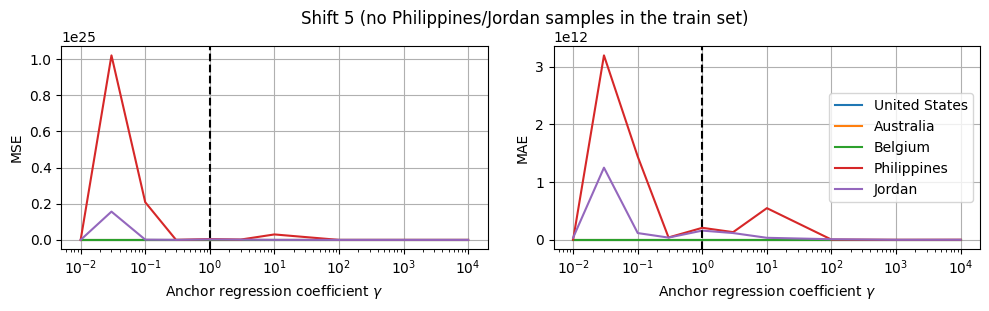

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
for country in countries:
    axes[0].plot(gammas, all_mses[4][country], label=country)
    axes[1].plot(gammas, all_maes[4][country], label=country)

axes[0].axvline(x=1.0, c='k', linestyle='--')
axes[0].set_xscale('log')
axes[0].grid()
axes[0].set_xlabel(r'Anchor regression coefficient $\gamma$')
axes[0].set_ylabel('MSE')

axes[1].axvline(x=1.0, c='k', linestyle='--')
axes[1].set_xscale('log')
axes[1].grid()
axes[1].set_xlabel(r'Anchor regression coefficient $\gamma$')
axes[1].set_ylabel('MAE')
axes[1].legend(loc='right', bbox_to_anchor=(1.0, 0.5), ncol=1)

plt.tight_layout()
fig.suptitle('Shift 5 (no Philippines/Jordan samples in the train set)', x=0.53, y=1.02)
plt.show()